# Spatial trajectory inference analysis tutorial

In this tutorial, we are using both spatial information and gene expression profile to perform spatial trajectory inference to explore the progression of Ductal Carcinoma in situ (DCIS) - Invasive Ductal Cancer (IDC)

Source: https://support.10xgenomics.com/spatial-gene-expression/datasets

## 1. Preparation

We are trying to keep it focus on spatial trajectory inference then every step from reading data, processing to clustering, we will give the code here to easier for user to use.

### Read and preprocess data

In [1]:
import stlearn as st
import scanpy as sc
sc.settings.verbosity = 3 
st.settings.set_figure_params(dpi=120)
# Reading data
data = st.Read10X(path="path_to_BCBA")
# Save raw_count
data.layers["raw_count"] = data.X
# Preprocessing
st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.log1p(data)
# Keep raw data
data.raw = data
st.pp.scale(data)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


### Clustering data

In [2]:
# Run PCA
st.em.run_pca(data,n_comps=50,random_state=0)
# Tiling image
st.pp.tiling(data,out_path="tiling",crop_size = 40)
# Using Deep Learning to extract feature
st.pp.extract_feature(data)
# Apply stSME spatial-PCA option
st.spatial.morphology.adjust(data,use_data="X_pca",radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology',random_state=0)
st.tl.clustering.louvain(data,random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


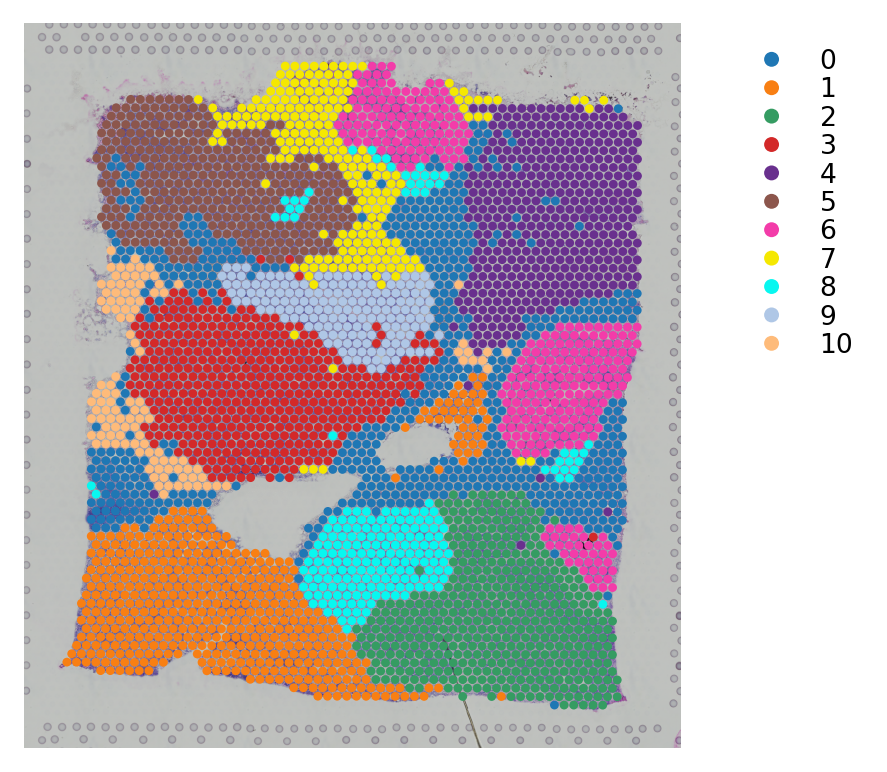

In [14]:
st.pl.cluster_plot(data,use_label="louvain",tissue_alpha=1,spot_size=7,show_legend=True)

The annotation is added to adata.obs['louvain_anno']


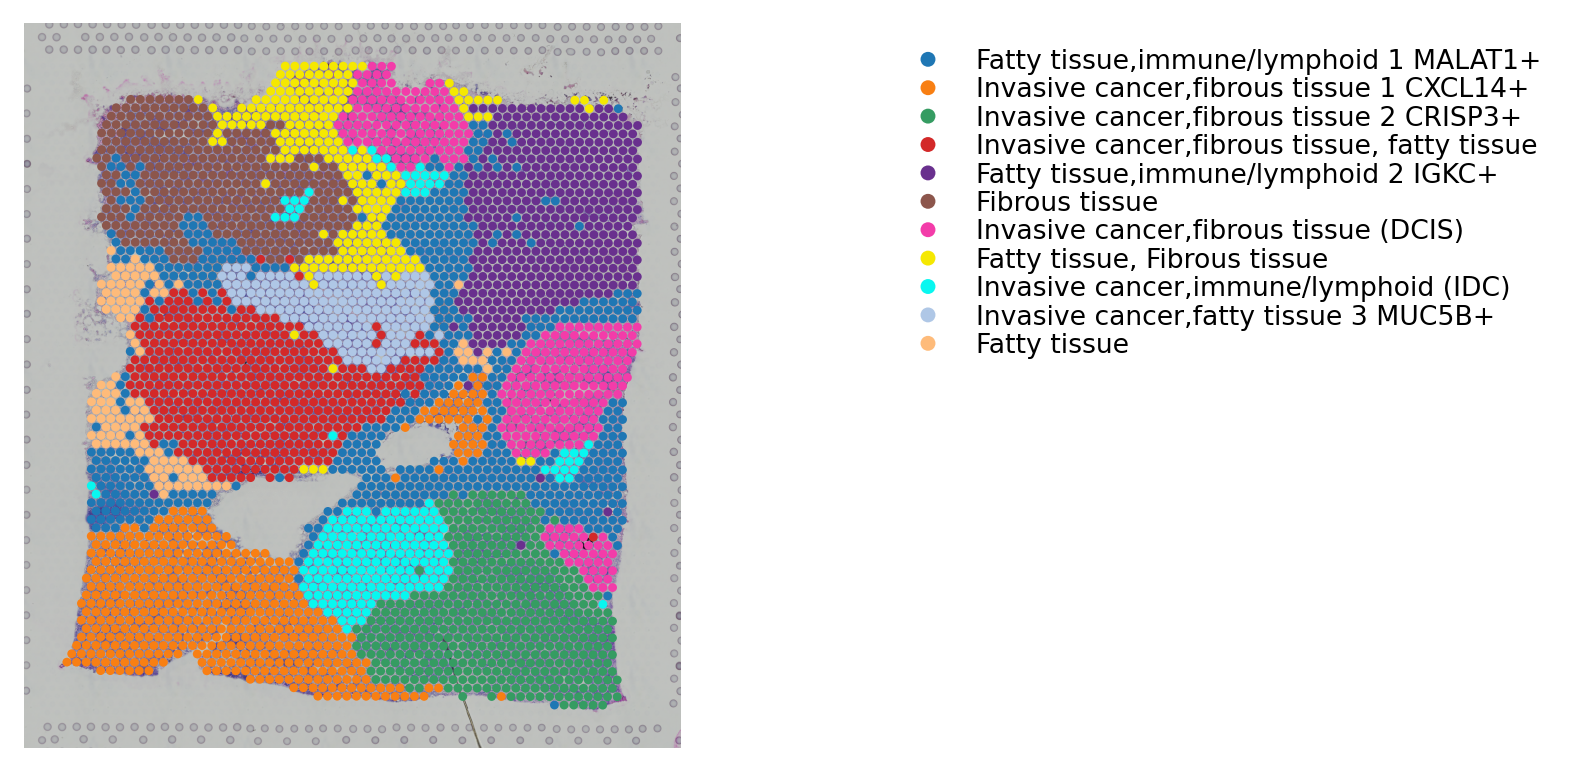

In [26]:
st.add.annotation(data,label_list=['Fatty tissue,immune/lymphoid 1 MALAT1+',
                                   'Invasive cancer,fibrous tissue 1 CXCL14+',
                                   'Invasive cancer,fibrous tissue 2 CRISP3+',
                                   'Invasive cancer,fibrous tissue, fatty tissue',
                                   'Fatty tissue,immune/lymphoid 2 IGKC+',
                                   'Fibrous tissue',
                                   'Invasive cancer,fibrous tissue (DCIS)',
                                   'Fatty tissue, Fibrous tissue',
                                   'Invasive cancer,immune/lymphoid (IDC)' ,
                                   'Invasive cancer,fatty tissue 3 MUC5B+',
                                   'Fatty tissue'],
                 use_label="louvain")
st.pl.cluster_plot(data,use_label="louvain_anno",tissue_alpha=1,spot_size=7,show_legend=True)

## 2. Spatial trajectory inference

### Choosing root

3733 is the index of the spot that we chose as root. It in the DCIS cluster (6).
We recommend the root spot should be in the end/begin of a cluster in UMAP space. You can find min/max point of a cluster in UMAP as root.

In [28]:
data.uns["iroot"] = 3733
st.spatial.trajectory.pseudotime(data,eps=50,use_rep="X_pca",use_sme=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_diffmap_morphology']


### Spatial trajectory inference - global level

We run the global level of pseudo-time-space (PSTS) method to reconstruct the spatial trajectory between cluster 6 (DCIS) and 8 (lesions IDC)

Screening PTS global graph...


Screening: 100%|██████████ [ time left: 00:00 ]
Calculating: 100%|██████████ [ time left: 00:00 ]


Calculate the graph dissimilarity using Laplacian matrix...
The optimized weighting is: 0.35
Start to construct the trajectory: 6 -> 8


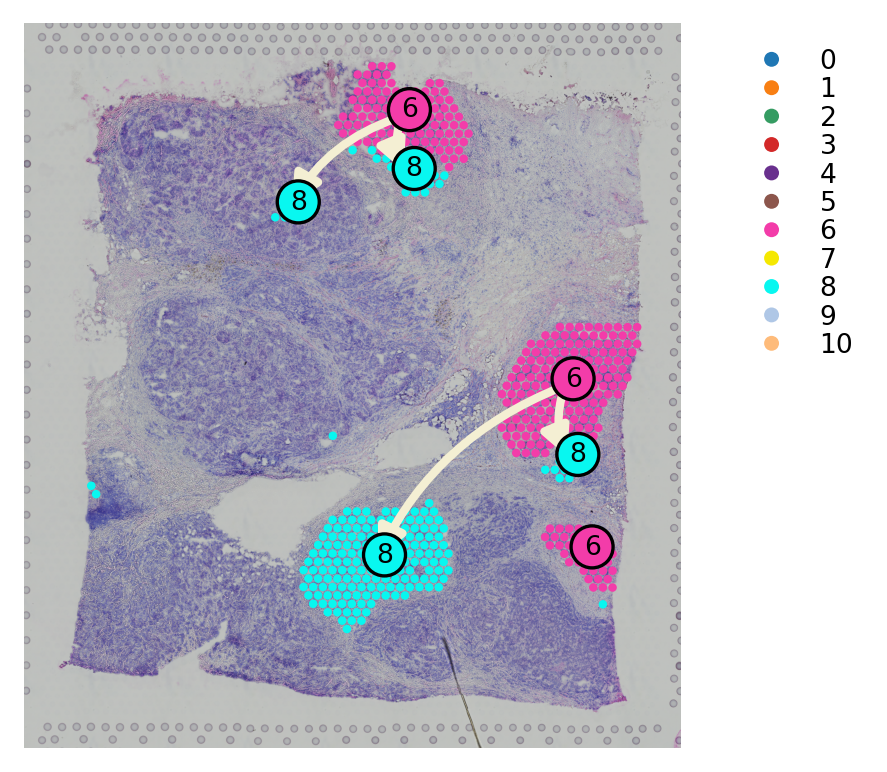

In [29]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="louvain",list_cluster=[6,8])
st.pl.cluster_plot(data,use_label="louvain",show_trajectory=True,list_cluster=[6,8],show_subcluster=False)


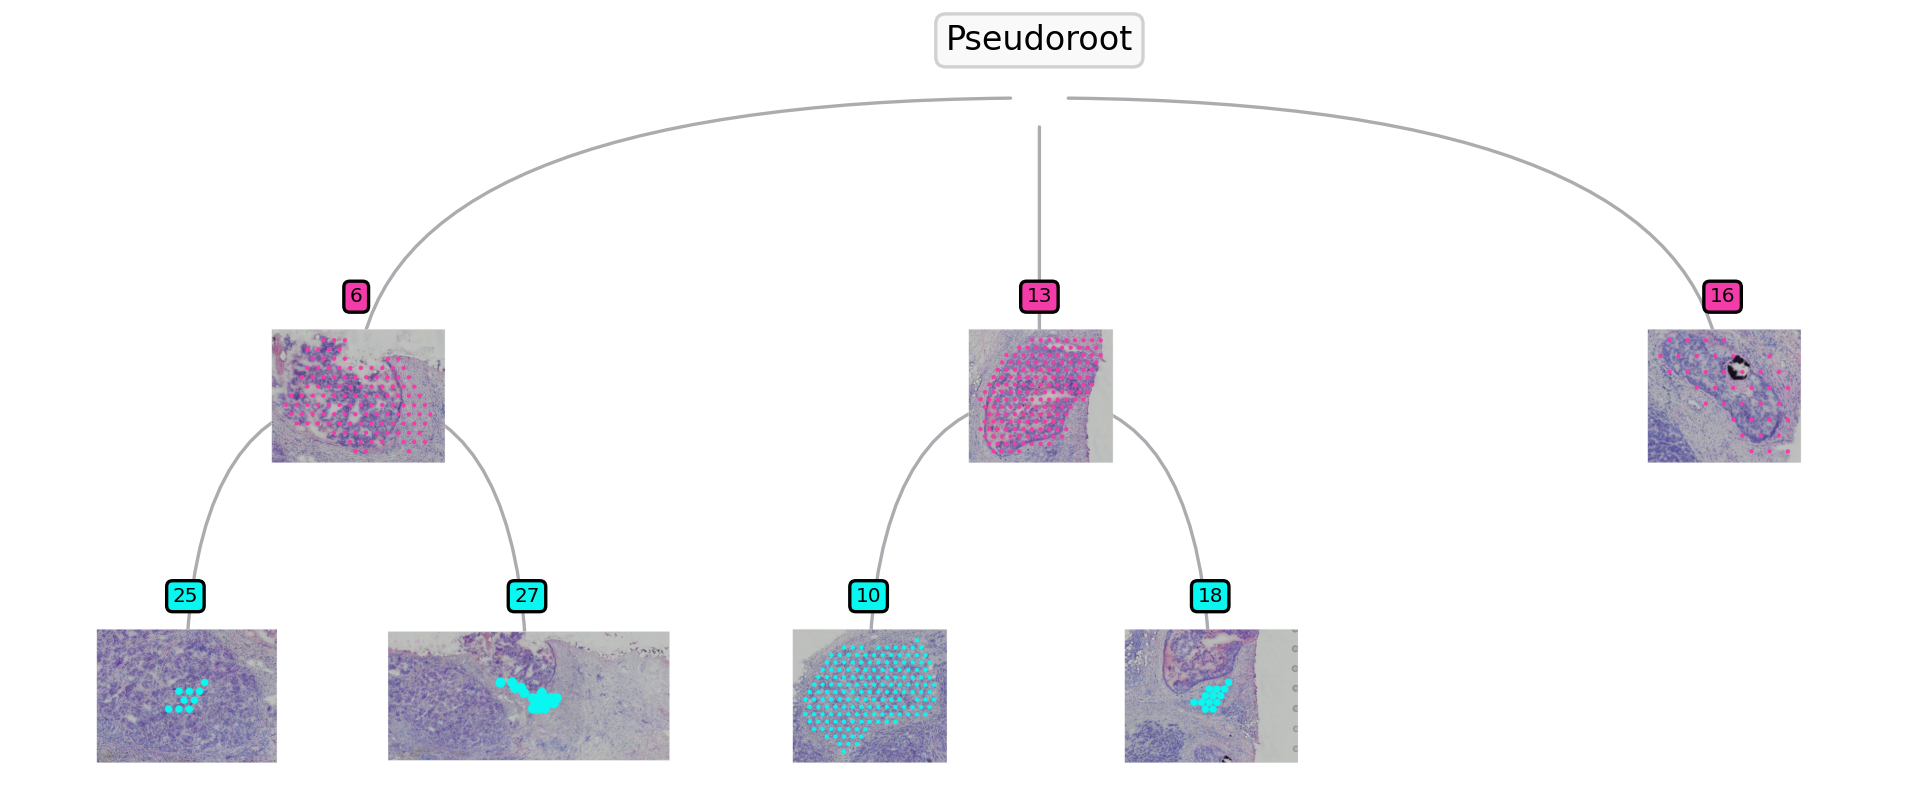

In [30]:
st.pl.trajectory.tree_plot(data)

### Transition markers detection

Based on the spatial trajectory/tree plot, we can see 2 clades are started from sub-cluster 6 and 13.
Then we run the function to detect the highly correlated genes with the PSTS values.

In [53]:
st.spatial.trajectory.detect_transition_markers_clades(data,clade=6,use_raw_count=False,cutoff_spearman=0.3)

Detecting the transition markers of clade_6...
Transition markers result is stored in adata.uns['clade_6']


In [54]:
st.spatial.trajectory.detect_transition_markers_clades(data,clade=13,use_raw_count=False,cutoff_spearman=0.3)

Detecting the transition markers of clade_13...
Transition markers result is stored in adata.uns['clade_13']


For the transition markers plot, genes from left side (red) are negatively correlated with the spatial trajectory and genes from right side (blue) are positively correlated with the spatial trajectory.

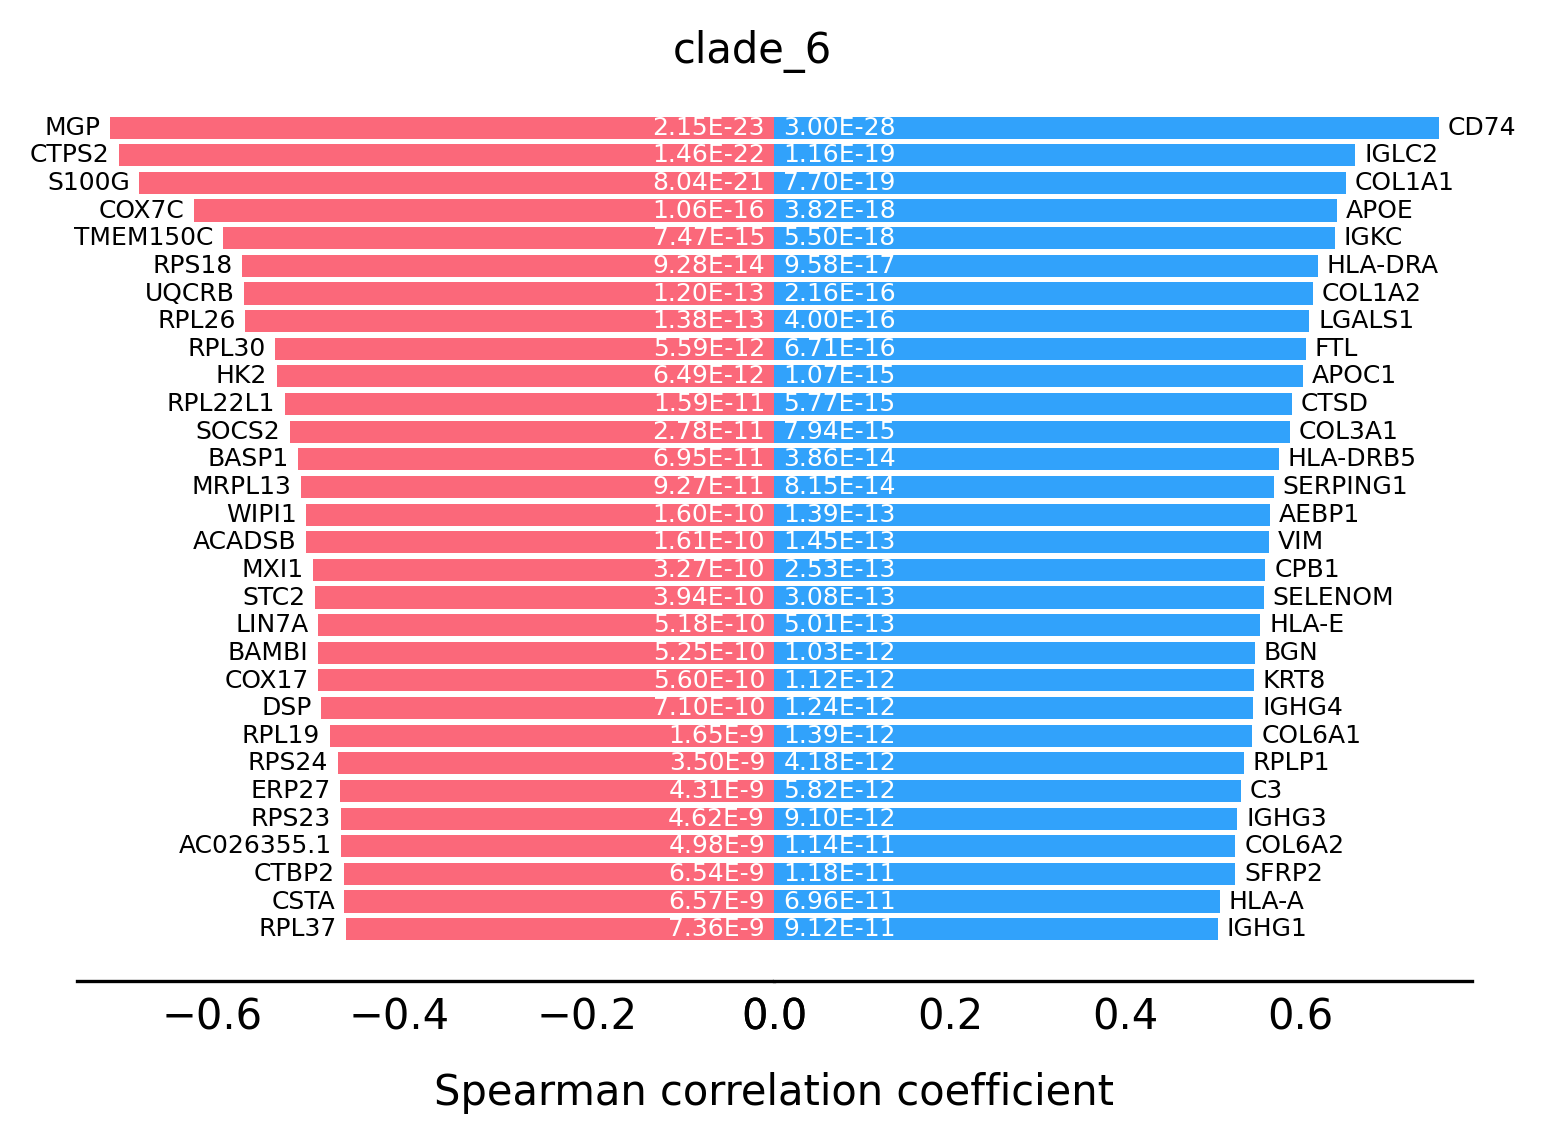

In [55]:
st.pl.trajectory.transition_markers_plot(data,top_genes=30,trajectory="clade_6")

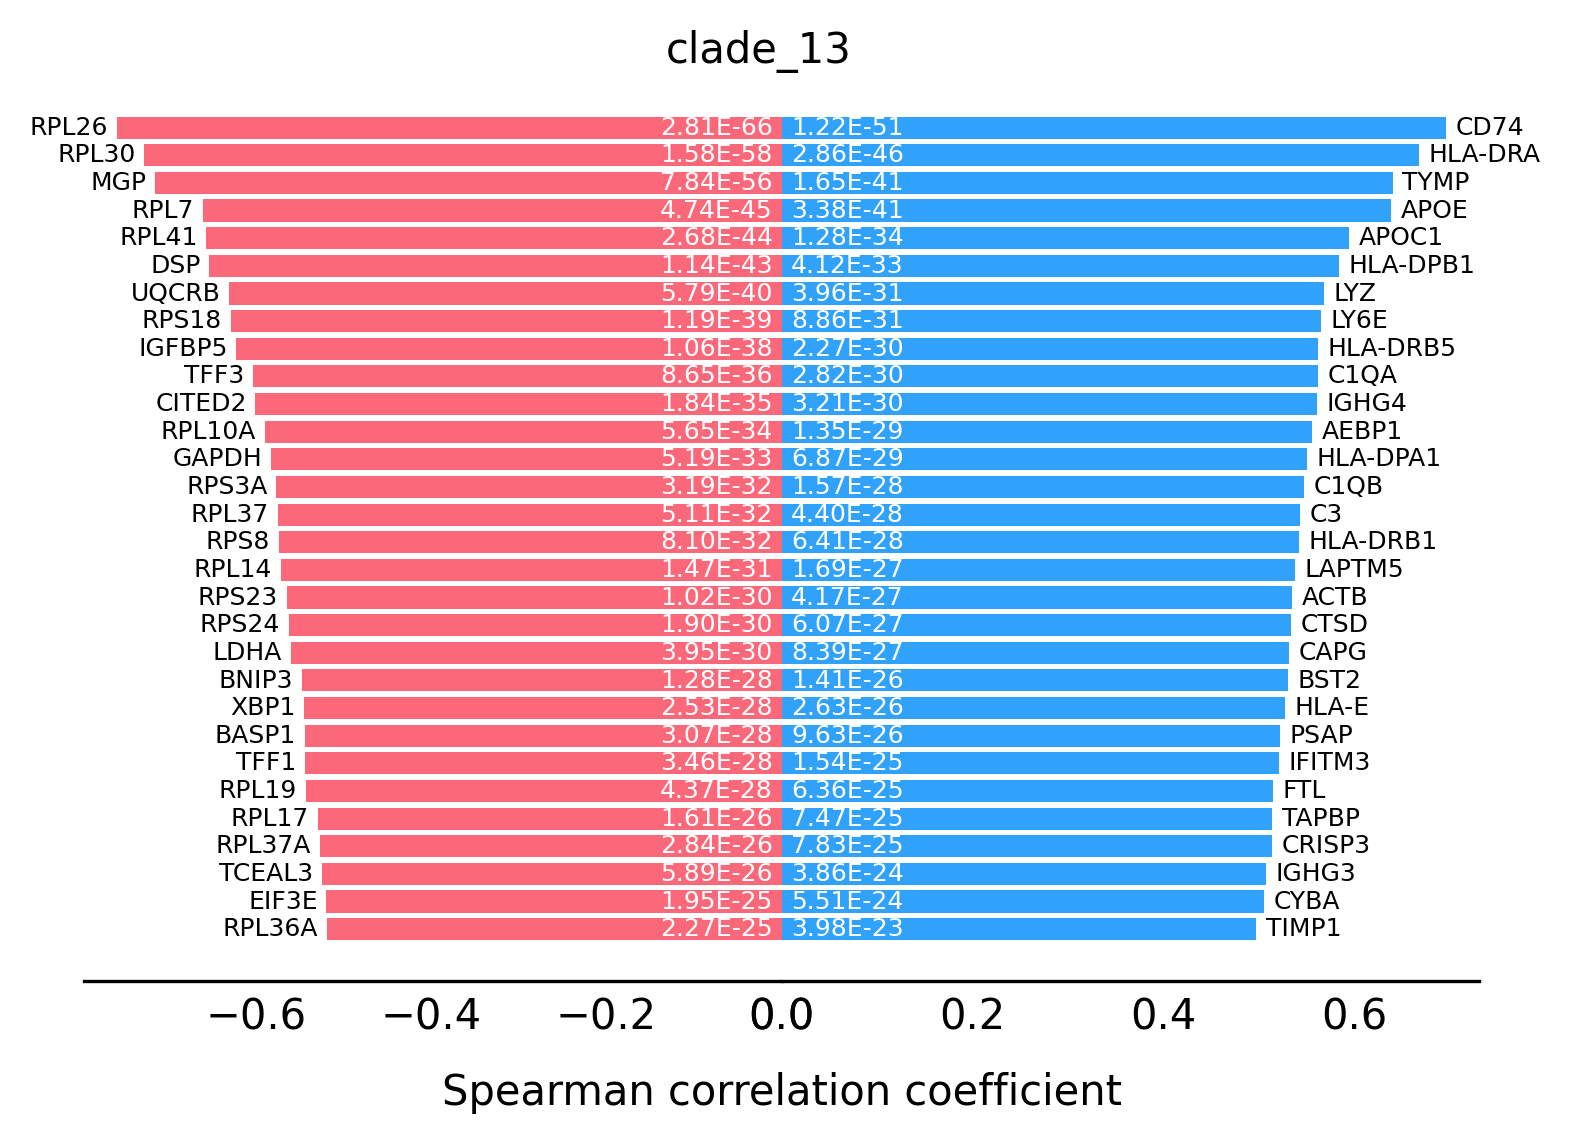

In [56]:
st.pl.trajectory.transition_markers_plot(data,top_genes=30,trajectory="clade_13")

We also provide a function to compare the transition markers between two clades.

In [57]:
st.spatial.trajectory.compare_transitions(data,trajectories=("clade_6","clade_13"))

The result of comparison between clade_6 and clade_13 stored in 'adata.uns['compare_result']'


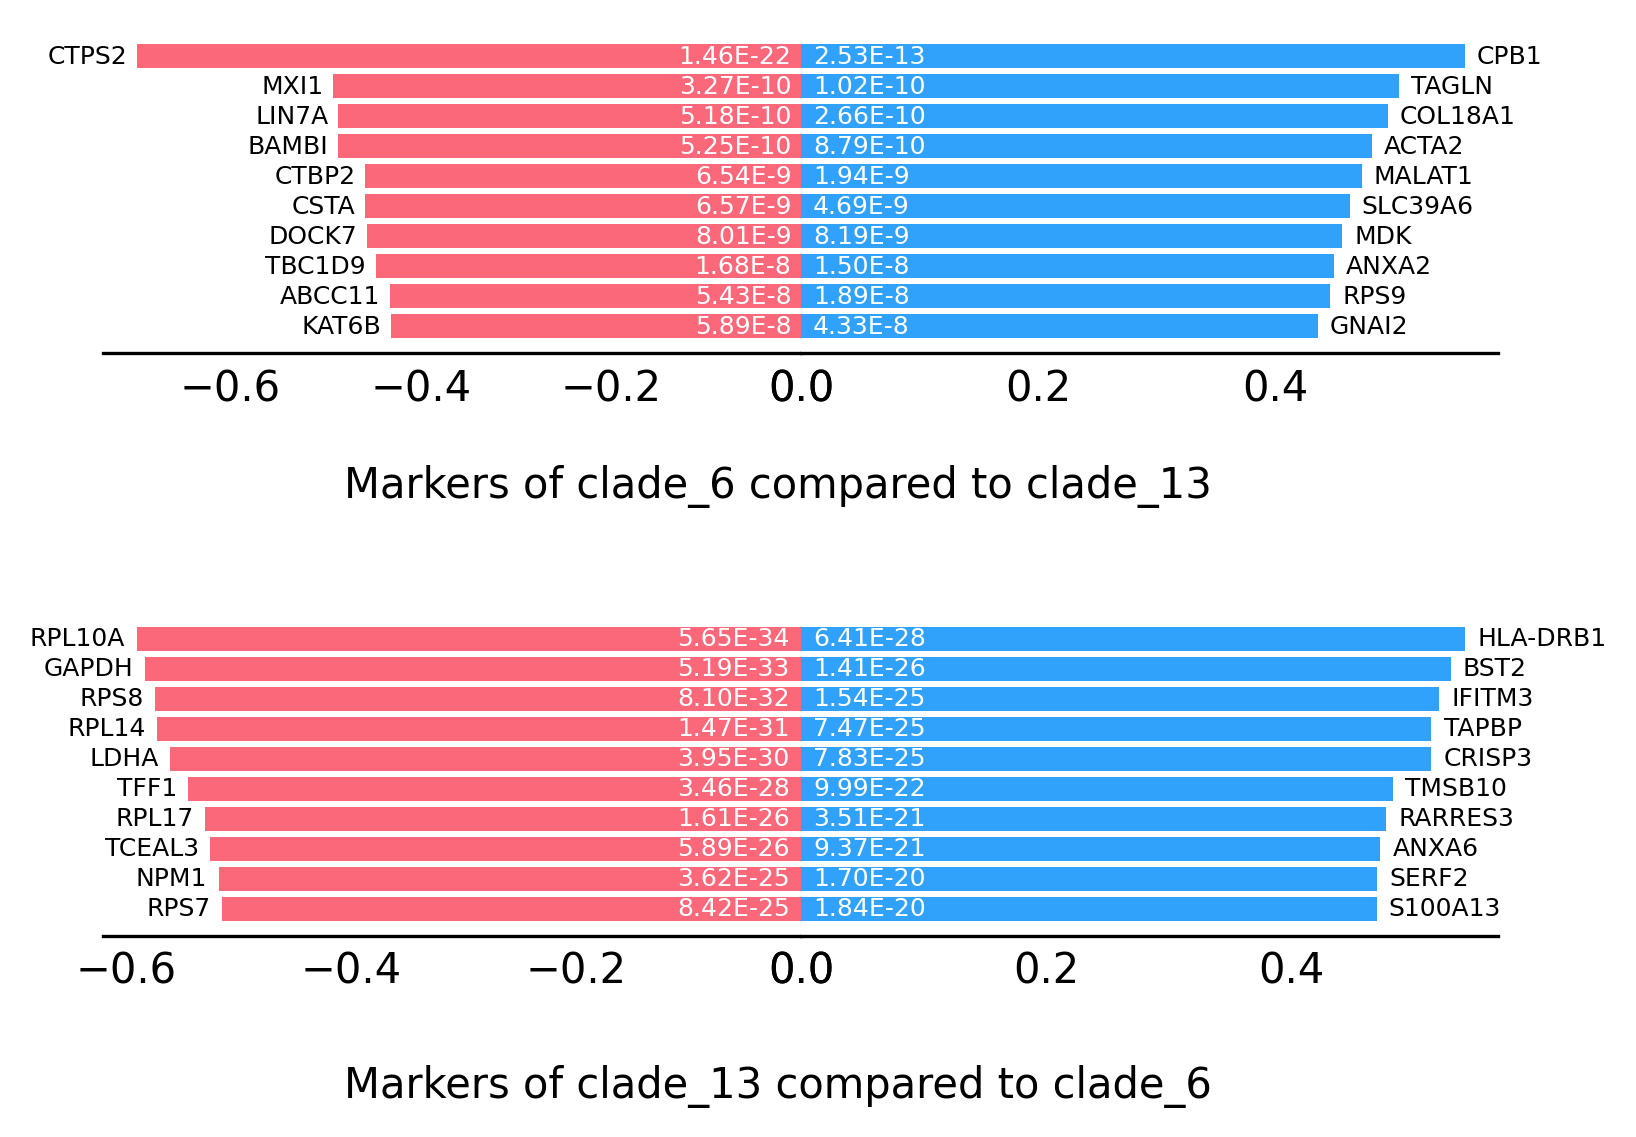

In [58]:
st.settings.set_figure_params(dpi=150)
st.pl.trajectory.DE_transition_plot(data,top_genes=10)

We can visualize some genes that different between two clades.

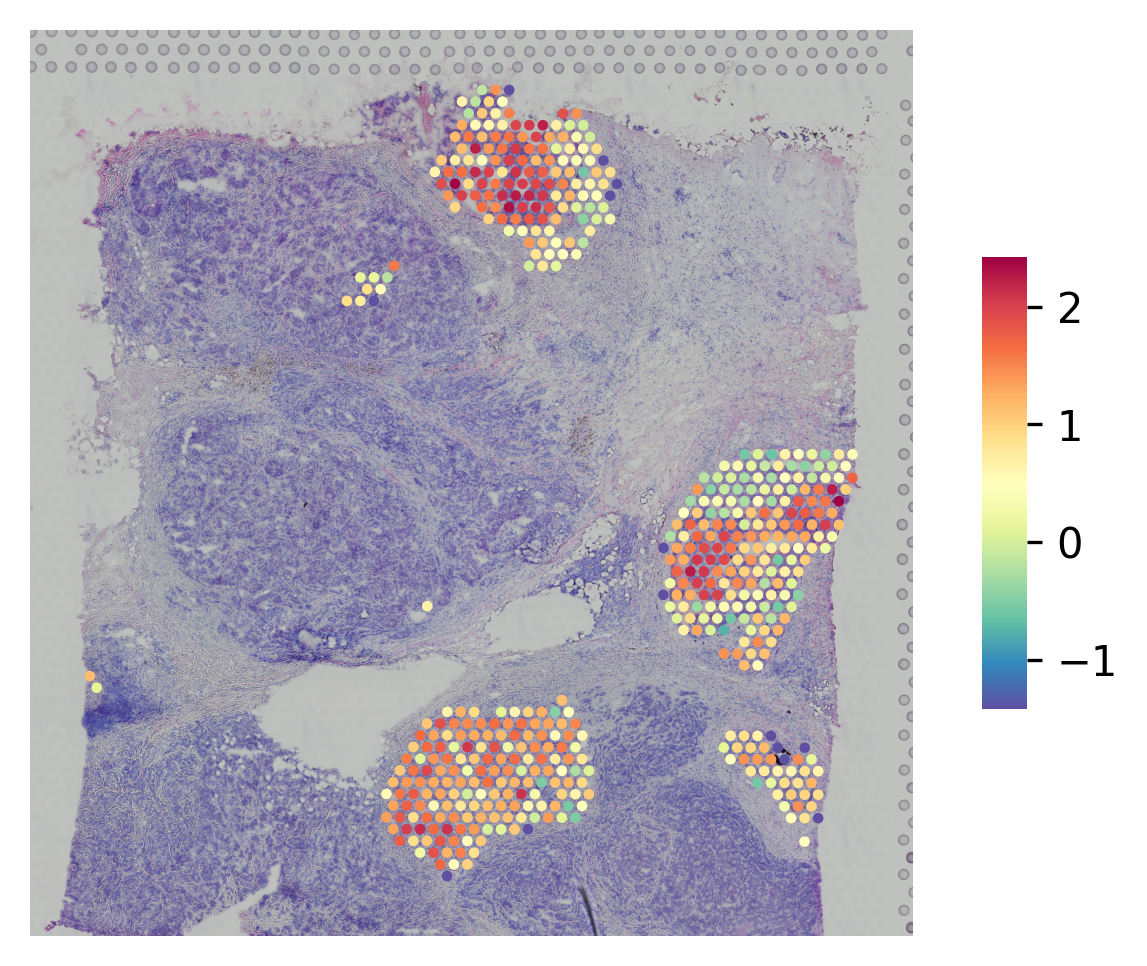

In [70]:
st.pl.gene_plot(data,gene_symbols="CTPS2",list_clusters=[6,8])

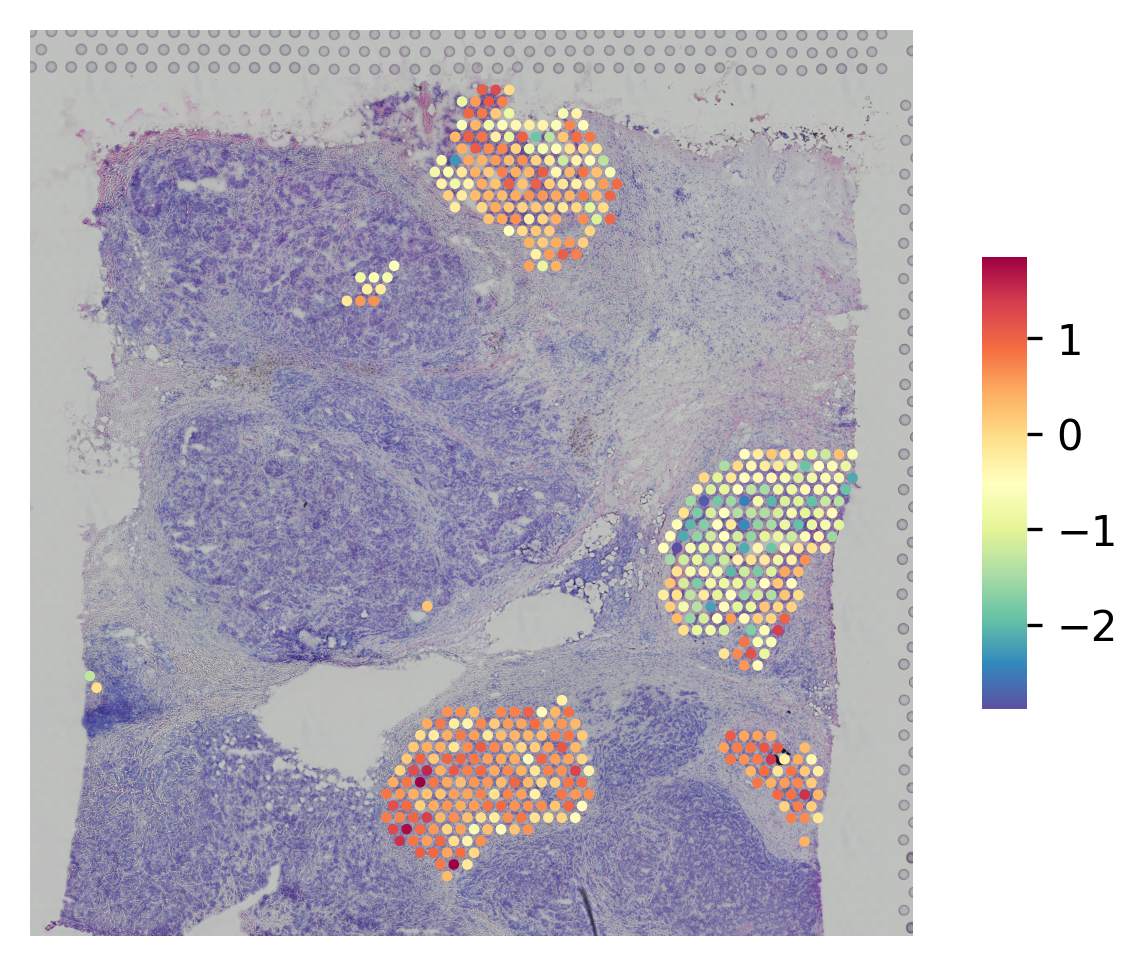

In [71]:
st.pl.gene_plot(data,gene_symbols="IFITM3",list_clusters=[6,8])